In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import cv2
import imghdr
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Avoid OOM errors by setting GPU Memory Consuption
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Remove dodgy images

In [3]:
data_dir = "/Users/orestisvaggelis/Desktop/DL/DLClassifier/data"
image_exts = ["jpeg", "jpg", "bmp", "png"]

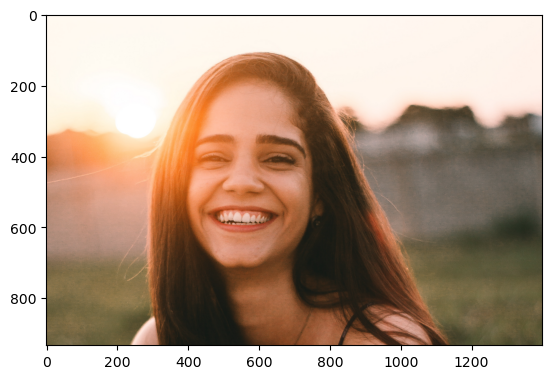

In [4]:
img = cv2.imread(os.path.join(data_dir, "happy", "1HEoLBLidT2u4mhJ0oiDgig.png"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
for image_class in os.listdir(data_dir):                                            # happy, sad
    for image in os.listdir(os.path.join(data_dir, image_class)):                   # looping through every image
        image_path = os.path.join(data_dir, image_class, image)
        try:                                                                
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:                                               # if not a valid image or valid extension -> remove it
                print("Image is not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

Load Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 187 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [17]:
# Get another batch from the iterator
batch = data_iterator.next()

In [18]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [19]:
# Class 0 = happy, Class 1 = sad
batch[1]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0], dtype=int32)

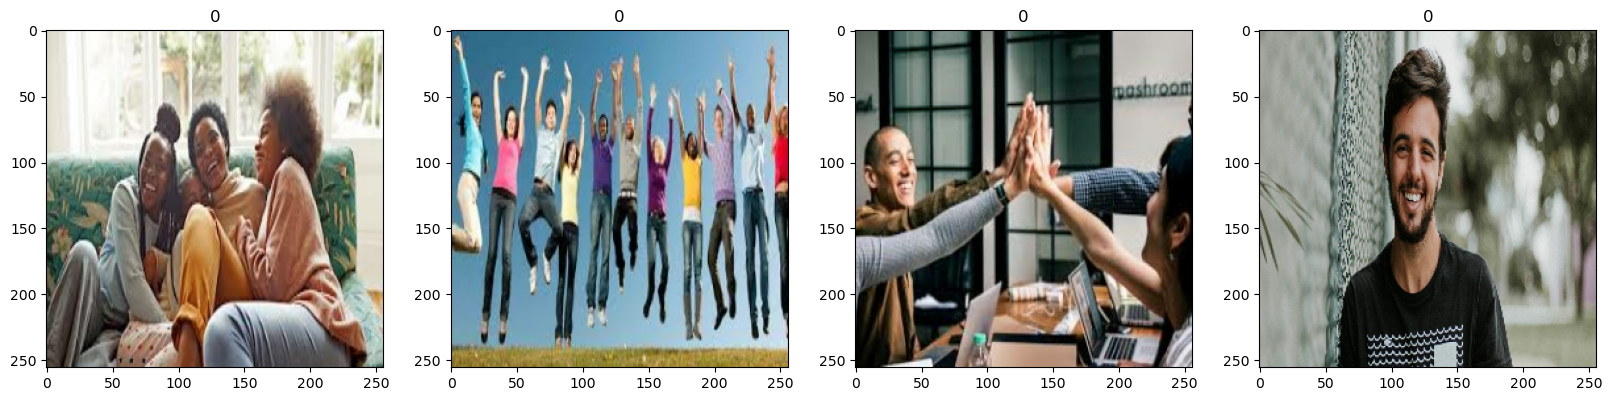

In [20]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Data Preprocessing

In [21]:
data = data.map(lambda x, y: (x/255, y))

In [22]:
# Split data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

# train_size + val_size + test_size == len(data)

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Build Deep Learning Model

In [24]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation = "relu", input_shape = (256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation = "relu"))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [25]:
model.compile(optimizer = "adam", loss = tf.losses.BinaryCrossentropy(), metrics = ["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Train the model

In [27]:
logdir = "/Users/orestisvaggelis/Desktop/DL/DLClassifier/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [28]:
history = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20


2023-01-20 22:43:48.992673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 2.3168 - accuracy: 0.4688

2023-01-20 22:43:51.500041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 386ms/step - loss: 2.3168 - accuracy: 0.4688 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 2/20
4/4 [==============================] - 2s 345ms/step - loss: 0.5914 - accuracy: 0.6953 - val_loss: 0.6548 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 341ms/step - loss: 0.6024 - accuracy: 0.6250 - val_loss: 0.5968 - val_accuracy: 0.6562
Epoch 4/20
4/4 [==============================] - 2s 343ms/step - loss: 0.6094 - accuracy: 0.6016 - val_loss: 0.6658 - val_accuracy: 0.5312
Epoch 5/20
4/4 [==============================] - 2s 341ms/step - loss: 0.5916 - accuracy: 0.6484 - val_loss: 0.6274 - val_accuracy: 0.5625
Epoch 6/20
4/4 [==============================] - 2s 342ms/step - loss: 0.5820 - accuracy: 0.6797 - val_loss: 0.5803 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 2s 341ms/step - loss: 0.5175 - accuracy: 0.7734 - val_loss: 0.4936 - val_accuracy: 0.8438
Epoch 8/20
4/4 [===============

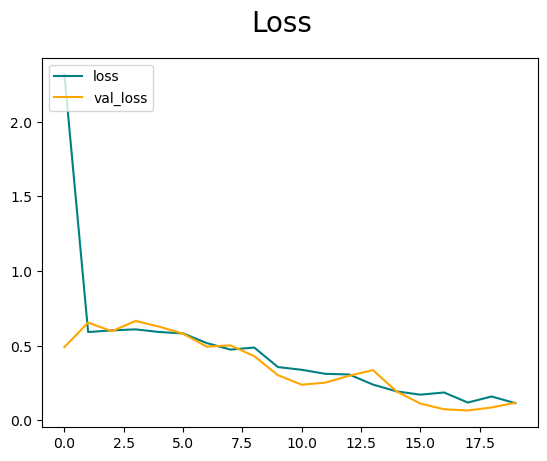

In [29]:
fig = plt.figure()
plt.plot(history.history["loss"], color = "teal", label = "loss")
plt.plot(history.history["val_loss"], color = "orange", label = "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.legend(loc = "upper left")
plt.show()